# KNN-regressor
Use k nearest neighbours to make prediction about process output

In [1]:
import pandas as pd
from statistics import mean
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

import scipy.stats as stats
import math
from scipy.stats import norm

from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### Wczytaj i oczyść dane

In [2]:
def changeDateToSeconds(df):
    first = df["date"][0]
    df["date"] = df["date"].apply(lambda timestamp: (timestamp-first).seconds)
    return df

def readDataFromExcel(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet, na_values=[" Bad Data","Bad Data"])
    df["date"] = pd.to_datetime(df["date"])
    df = changeDateToSeconds(df)
    return df

df2 = readDataFromExcel("./data/K-1_MI.xlsx", "d2")
df3 = readDataFromExcel("./data/K-1_MI.xlsx", "d3")
df5 = readDataFromExcel("./data/K-1_MI.xlsx", "d5")
df6 = readDataFromExcel("./data/K-1_MI.xlsx", "d6")

df6 = df6.iloc[::5, :] # dopasuj okresy próbkowania

dataFrames = [df2, df3, df5, df6]

for i, df in enumerate(dataFrames):
    if np.isnan(np.sum(df.values)):
        dataFrames[i] = dataFrames[i].interpolate()

In [3]:
all_dfs = dataFrames[0].append(dataFrames[1]).append(dataFrames[2]).append(dataFrames[3])
scaler = preprocessing.StandardScaler()
pure_data = all_dfs.drop(["date","LT2", "LT3", "LT4", "TMA","PWA", "PWF", "WP2", "WS1","WS2", "TTWT"], axis=1)
columns = pure_data.columns
scaler.fit(pure_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [4]:
np.isnan(np.sum(pure_data))

FP05    False
LT1     False
TMB     False
TMC     False
TMD     False
TME     False
TMF     False
PWB     False
PWC     False
PWD     False
PWE     False
PP      False
PW1     False
PW2     False
O2A     False
O2B     False
WP1     False
WDP     False
TP1     False
TP2     False
DP      False
TS1     False
TS2     False
FWF     False
ZS1     False
ZS2     False
LT01    False
PT05    False
PT01    False
TS01    False
TS03    False
TS02    False
FW01    False
TS05    False
TS04    False
FW02    False
TTWS    False
PTWS    False
TW02    False
TW01    False
FW03    False
TW04    False
TW03    False
FW04    False
PTWT    False
PPW     False
dtype: bool

In [5]:
dataFrames[2]

,date,FP05,LT1,LT2,LT3,LT4,TMA,TMB,TMC,TMD,...,PTWS,TW02,TW01,FW03,TW04,TW03,FW04,TTWT,PTWT,PPW
0,0,1081.4991,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6470,538.6156,324.4563,0.0000,541.0661,310.4243,9.8722,176.4025,10.5377,3.4916
1,10,1081.4991,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6360,538.6156,324.4563,0.0000,541.0661,310.4243,9.8722,176.4025,10.5377,3.4916
2,20,1079.9686,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6360,538.6156,324.4563,0.0000,541.0661,310.4243,9.8722,176.4025,10.5377,3.4916
3,30,1079.9686,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6195,538.6156,324.4563,0.0000,539.9727,310.4243,9.8722,176.4025,10.5268,3.4916
4,40,1079.9686,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6195,538.6156,324.4563,0.0000,539.9727,310.4243,9.8722,176.4025,10.5268,3.4916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,9940,1072.3688,15.1995,2.3119,11.714,9.9923,72.1319,57.5103,54.3721,58.5927,...,19.4740,539.5197,321.0358,0.0000,540.4623,306.1097,10.4318,176.7647,10.4490,3.4771
995,9950,1072.3688,15.1995,2.3119,11.714,9.9923,72.1319,57.5103,54.3721,58.5927,...,19.4740,539.5197,321.0358,0.0000,540.4623,306.1097,10.4318,176.7647,10.4490,3.4771
996,9960,1072.3688,15.1995,2.3119,11.714,9.9923,72.1319,57.5103,54.3721,58.5927,...,19.4863,539.5197,321.0358,0.0000,540.4623,306.1097,10.4318,176.7647,10.4490,3.4771
997,9970,1072.3688,15.1995,2.3119,11.714,9.9923,72.1319,57.5103,54.3721,58.5927,...,19.4863,539.5197,322.8242,5.0621,540.4623,306.1097,10.4318,176.7647,10.4300,3.4771


In [6]:
scaledDataFrames = list()
for df in dataFrames:
    x = scaler.transform(df.drop(["date","LT2", "LT3", "LT4", "TMA","PWA", "PWF", "WP2", "WS1","WS2", "TTWT"], axis=1))
    scaledDataFrames.append(pd.DataFrame(x, columns=columns))

In [7]:
scaledDataFrames[0].head()

,FP05,LT1,TMB,TMC,TMD,TME,TMF,PWB,PWC,PWD,...,TTWS,PTWS,TW02,TW01,FW03,TW04,TW03,FW04,PTWT,PPW
0,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.270065,0.382458,-0.746469,0.934474,0.082002,-0.626244,0.862839,0.179704,0.688236
1,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.270065,0.382458,-0.746469,0.934474,0.082002,-0.626244,0.862839,0.179704,0.688236
2,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.243785,0.382458,-0.746469,0.934474,0.082002,-0.550439,0.862839,0.179704,0.633300
3,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.267982,0.382458,-0.628565,0.934474,0.082002,-0.550439,0.862839,0.179704,0.633300
4,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.267982,0.382458,-0.628565,0.934474,0.082002,-0.550439,0.862839,0.179704,0.633300


In [8]:
all_dfs = scaledDataFrames[0].append(scaledDataFrames[1]).append(scaledDataFrames[2]).append(scaledDataFrames[3])
scaled_inputs = all_dfs.drop(["LT01"], axis=1)

pca = PCA(0.99)
pca.fit(scaled_inputs)

principal_components = list()
for sdf in scaledDataFrames:
    pc = pca.transform(sdf.drop(["LT01"], axis=1))
    principal_components.append(pd.DataFrame(pc))

In [9]:
principal_components[1]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.312739,1.615754,0.484870,-2.536004,-2.628759,1.550710,2.038750,0.631258,-0.089762,-1.215412,...,0.140797,-0.151278,-0.104359,0.344573,-0.368779,-0.152940,-0.043080,-0.694963,0.702938,-0.228198
1,-2.311389,1.608818,0.529418,-2.529161,-2.622192,1.563108,2.058269,0.615750,-0.069935,-1.208095,...,0.138714,-0.157363,-0.092801,0.260429,-0.389350,-0.359204,-0.029871,-0.702170,0.733283,-0.241077
2,-2.300151,1.531973,0.483257,-2.460059,-2.510345,1.676326,2.074189,0.623687,0.028768,-1.117673,...,0.138124,-0.131698,-0.130817,0.504473,-0.307666,0.300225,-0.089197,-0.589492,0.511416,-0.199433
3,-2.428553,1.523189,0.372075,-2.335862,-2.490385,1.738897,2.055065,0.659087,0.065177,-1.329286,...,-0.062368,-0.222879,-0.233909,0.371338,-0.257799,0.300568,-0.104316,-0.397529,0.406336,-0.213006
4,-2.346854,2.335986,0.699577,-2.560440,-2.622807,1.383117,2.216472,0.933723,-0.321118,-1.390914,...,0.301353,-0.447505,-0.371151,0.153062,-0.468458,-0.226334,0.664766,0.485952,-0.201861,-0.070381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-2.716540,1.828202,-2.089027,2.358966,-2.375893,2.416021,-0.789296,-1.318293,-0.159809,0.166674,...,0.299828,-0.466643,0.192494,0.127466,0.381366,-0.058961,-0.487915,-0.223227,-0.153878,0.156268
995,-2.789207,1.756761,-1.984517,2.307838,-2.467238,2.396315,-0.758828,-1.501945,-0.195582,0.196209,...,0.421532,-0.325075,0.365970,0.201730,0.321970,-0.395371,-0.362788,-0.253312,-0.132797,0.194806
996,-2.751556,1.691950,-2.013758,2.270515,-2.377892,2.471481,-0.691258,-1.520885,-0.134580,0.346360,...,0.490669,-0.247954,0.391503,0.328702,0.379308,-0.301762,-0.333038,-0.257632,-0.132712,0.246810
997,-2.794712,1.714722,-1.892145,2.302016,-2.495500,2.397161,-0.741831,-1.611714,-0.161574,0.193655,...,0.487784,-0.276346,0.461310,0.153697,0.274312,-0.796498,-0.280459,-0.259483,-0.031533,0.200758


### KNNregressor

In [10]:
class KNNRegressor:
    def __init__(self, k=1):
        self.learning_set = list()
        self.k = k
        
    def add_data(self, data, output):
        self.learning_set.append((data, output))
        
    def find_distance(d1, d2):
        return np.linalg.norm(d1-d2)
    
    def predict(self, data):
        distances_iterator = map(lambda x: (KNNRegressor.find_distance(x[0], data), x[1]), self.learning_set)
        sorted_distances = sorted(distances_iterator, key=lambda x: x[0])
        
        nearest_neighbours = sorted_distances[:self.k]
        rate = list(map(lambda x: 1/(x+1), range(self.k)))
        outputs = list(map(lambda x: x[1], nearest_neighbours))
        
        model_output = sum(rate[g] * outputs[g] for g in range(len(rate))) / sum(rate)
#         model_output = mean(map(lambda x: x[1], nearest_neighbours))
        return model_output

TRAINTESTRATIO = 0.33
KN = 5

## LT01

In [11]:
df0 = principal_components[0].copy()
df0.insert(22, "LT01", scaledDataFrames[0]["LT01"].values)
[train0, test0] = train_test_split(df0, train_size=TRAINTESTRATIO, random_state=0)

df1 = principal_components[1].copy()
df1.insert(22, "LT01", scaledDataFrames[1]["LT01"].values)
[train1, test1] = train_test_split(df1, train_size=TRAINTESTRATIO, random_state=0)

df2 = principal_components[2].copy()
df2.insert(22, "LT01", scaledDataFrames[2]["LT01"].values)
[train2, test2] = train_test_split(df2, train_size=TRAINTESTRATIO, random_state=0)

df3 = principal_components[3].copy()
df3.insert(22, "LT01", scaledDataFrames[3]["LT01"].values)
[train3, test3] = train_test_split(df3, train_size=TRAINTESTRATIO, random_state=0)

In [12]:
train1

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,LT01
329,-2.849191,5.739859,1.379947,-0.164994,0.905995,-2.180371,0.162020,-0.669882,-0.515776,1.374686,...,-0.064773,-0.229165,0.578122,-0.715142,0.033341,-0.060990,0.042063,0.122735,-0.048210,-0.344686
480,-3.242605,5.597023,-0.139745,0.719992,1.875934,-2.206798,0.872453,-0.663000,-0.547985,-0.115737,...,0.099773,0.474070,0.084551,0.249439,-0.073707,0.403971,-0.134380,0.134315,-0.003861,0.758463
498,-3.765460,5.634690,-0.398116,1.247002,2.209464,-2.844667,0.347026,-0.687949,-0.336330,-0.338660,...,0.439517,0.089432,-0.562439,-0.384945,0.102405,0.204430,0.078231,0.536634,-0.271737,-2.095922
869,-2.989239,0.943664,-1.892944,1.918039,-1.511915,1.873543,-0.539950,-1.765020,0.116612,0.072724,...,-0.419648,0.405762,0.602959,0.401853,1.129999,-0.258236,0.098526,-0.094842,-0.029240,0.913474
405,-2.656835,4.490063,-0.198851,0.648081,0.439777,-0.921539,0.969315,-0.146621,-0.414775,0.362242,...,0.253361,0.176728,0.018282,0.793613,-0.514923,0.770569,0.382223,-0.096437,0.267179,1.359423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,-2.714105,0.196513,-2.156920,1.788701,-3.371096,2.125765,-0.379685,-0.607953,0.186925,0.159498,...,-0.111126,-0.196233,0.360863,-0.144136,0.202011,-0.219597,0.082182,0.016578,-0.190650,-1.099313
192,-2.708805,5.001125,1.285191,-1.244193,0.173571,-0.680320,0.655700,0.632174,-0.204810,0.466294,...,-0.607010,0.106519,-0.047073,-0.230149,-0.341659,0.177830,0.038211,0.236969,0.274881,-0.779669
629,-4.298357,3.179791,-1.950107,2.277142,0.969638,-0.574371,0.169091,-0.067335,0.300998,-0.450022,...,0.864694,0.062891,-0.349251,0.149163,0.112134,-0.166977,0.027389,-0.026610,-0.203357,-0.518013
559,-4.296378,2.765387,-2.186161,2.282660,0.990799,-0.973831,-0.146650,0.374933,0.526917,-0.698506,...,-0.019009,-0.038728,-0.557692,-0.065596,-0.133536,0.039860,-0.031344,0.526230,-0.482711,0.016512


In [13]:
knn = KNNRegressor(k=KN)
for idx, row in enumerate(zip(train0.drop(["LT01"],axis=1).iterrows(), train0["LT01"])):
    inputs = row[0][1].values
    output = row[1]
    knn.add_data(inputs, output)
    
for idx, row in enumerate(zip(train1.drop(["LT01"],axis=1).iterrows(), train1["LT01"])):
    inputs = row[0][1].values
    output = row[1]
    knn.add_data(inputs, output)
    
for idx, row in enumerate(zip(train2.drop(["LT01"],axis=1).iterrows(), train2["LT01"])):
    inputs = row[0][1].values
    output = row[1]
    knn.add_data(inputs, output)
    
for idx, row in enumerate(zip(train3.drop(["LT01"],axis=1).iterrows(), train3["LT01"])):
    inputs = row[0][1].values
    output = row[1]
    knn.add_data(inputs, output)

### Data set 0

In [14]:
model_outputs0 = list()
real_outputs0 = list()
errors0 = list()
for i in range(len(test0)):
    model_output = knn.predict(test0.drop(["LT01"],axis=1).values[i])
    real_output = test0["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs0.append(model_output)
    real_outputs0.append(real_output)
    errors0.append(error)

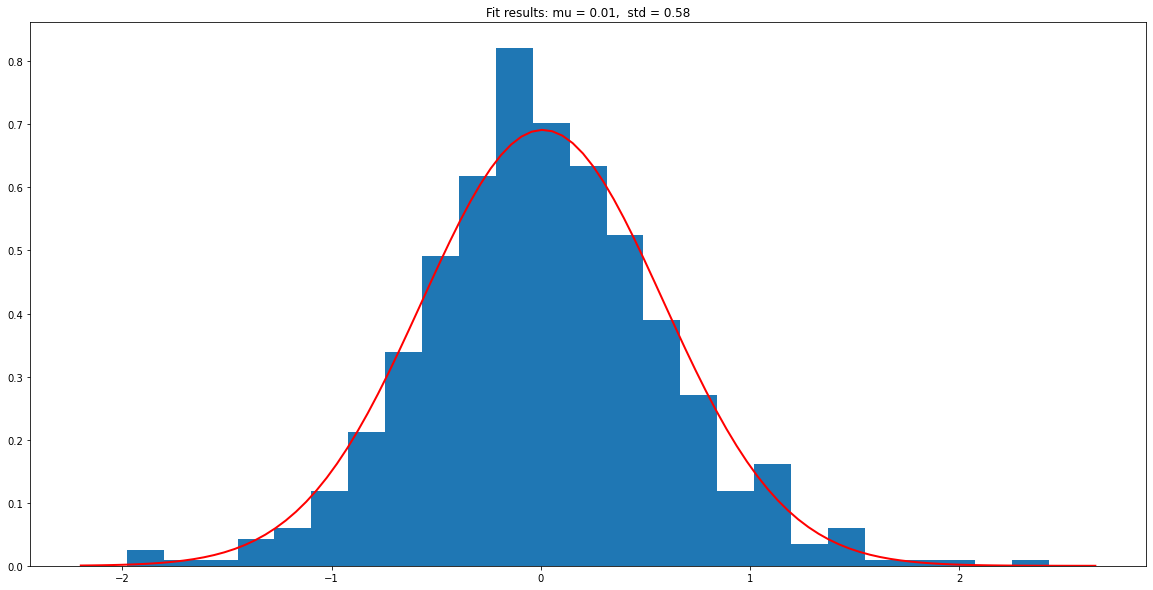

In [15]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors0, bins=25, density=True)

mu = np.array(errors0).mean()
sigma = np.array(errors0).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.7123415609761528


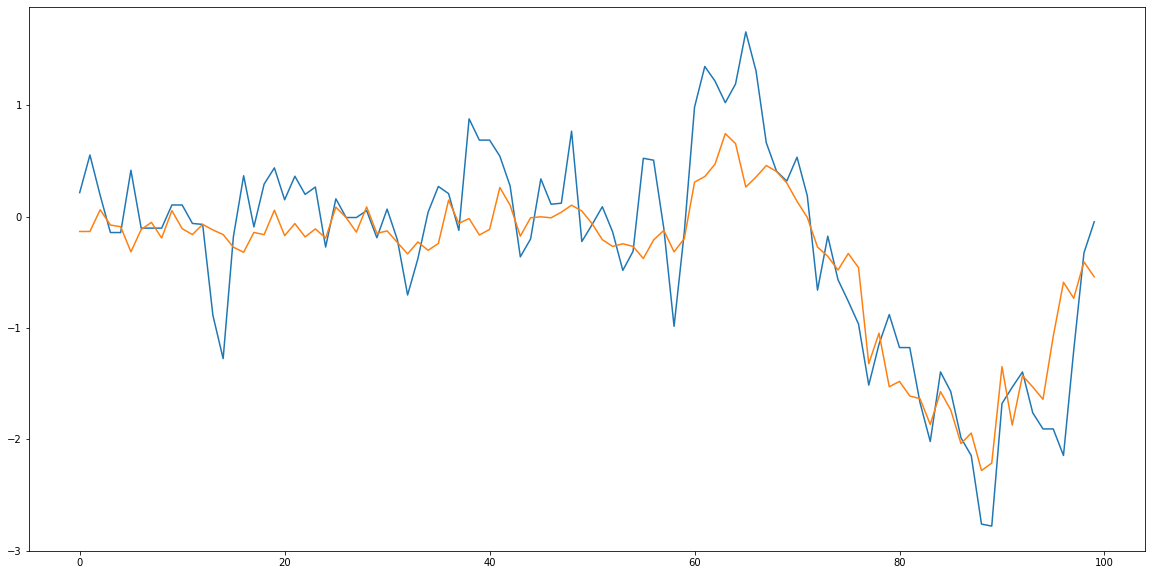

In [16]:
model_outputs0_all = list()
real_outputs0_all = list()
errors0_all = list()
for i in range(len(df0)):
    model_output = knn.predict(df0.drop(["LT01"],axis=1).values[i])
    real_output = df0["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs0_all.append(model_output)
    real_outputs0_all.append(real_output)
    errors0_all.append(error)

plt.plot(real_outputs0_all[:100])
plt.plot(model_outputs0_all[:100])
r2_lt_0 = r2_score(real_outputs0_all, model_outputs0_all)
print(r2_lt_0)

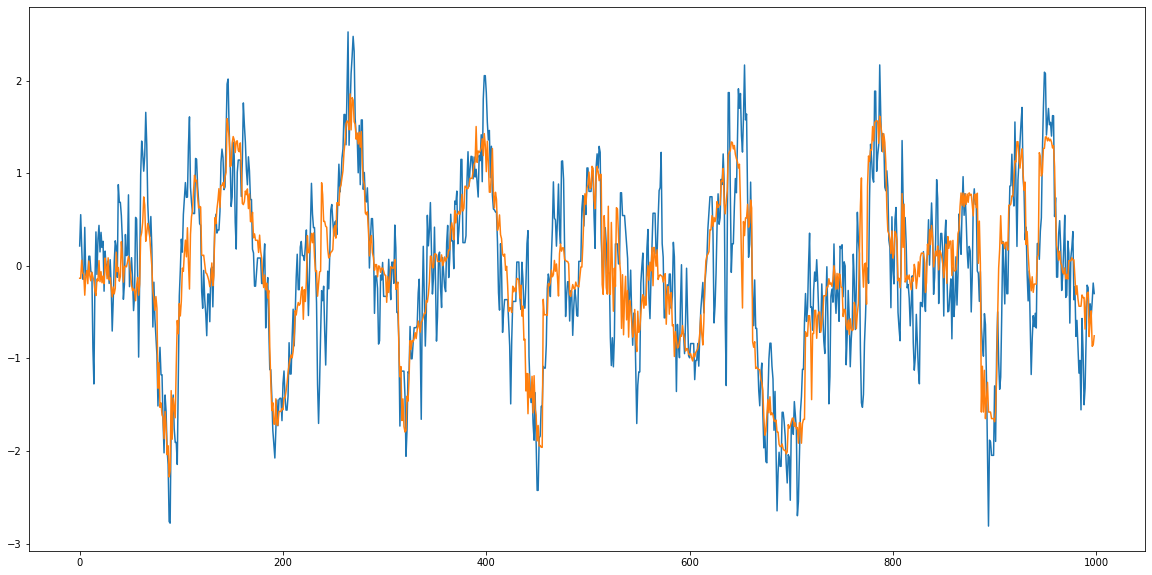

In [17]:
plt.plot(real_outputs0_all)
plt.plot(model_outputs0_all)

### Data set 1

In [18]:
model_outputs1 = list()
real_outputs1 = list()
errors1 = list()
for i in range(len(test1)):
    model_output = knn.predict(test1.drop(["LT01"],axis=1).values[i])
    real_output = test1["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs1.append(model_output)
    real_outputs1.append(real_output)
    errors1.append(error)

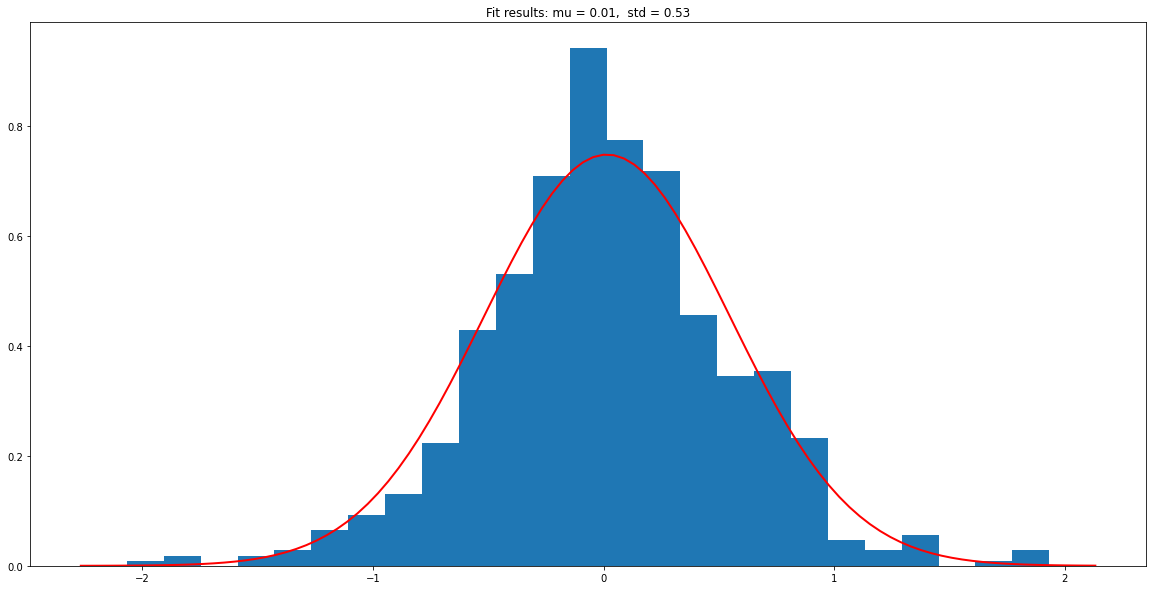

In [19]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors1, bins=25, density=True)

mu = np.array(errors1).mean()
sigma = np.array(errors1).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.6105838775782819


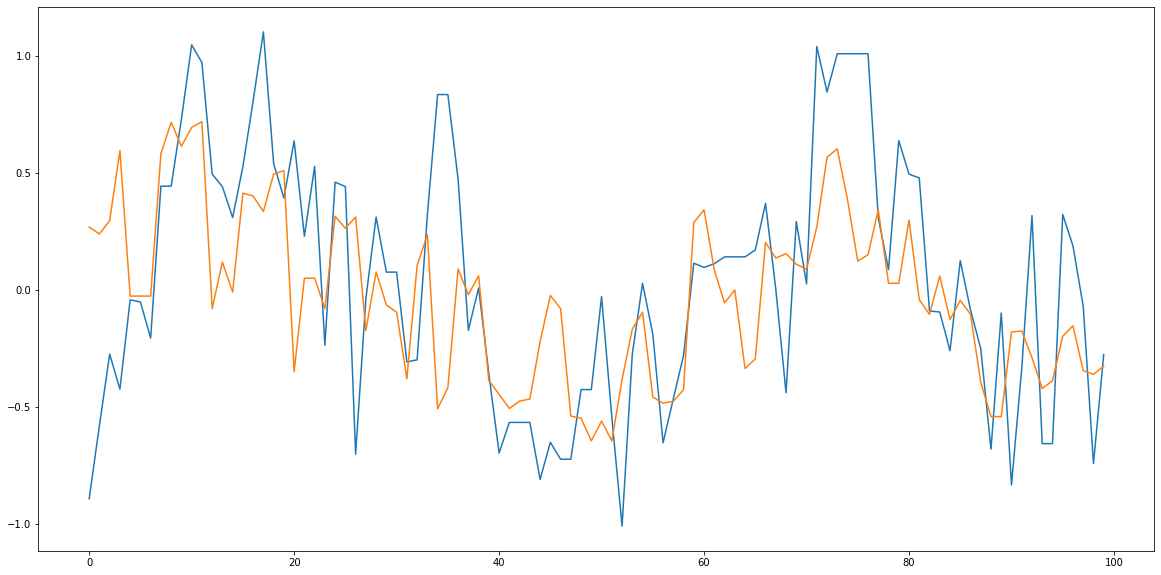

In [20]:
model_outputs1_all = list()
real_outputs1_all = list()
errors1_all = list()
for i in range(len(df1)):
    model_output = knn.predict(df1.drop(["LT01"],axis=1).values[i])
    real_output = df1["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs1_all.append(model_output)
    real_outputs1_all.append(real_output)
    errors1_all.append(error)

plt.plot(real_outputs1_all[:100])
plt.plot(model_outputs1_all[:100])
r2_lt_1 = r2_score(real_outputs1_all, model_outputs1_all)
print(r2_lt_1)

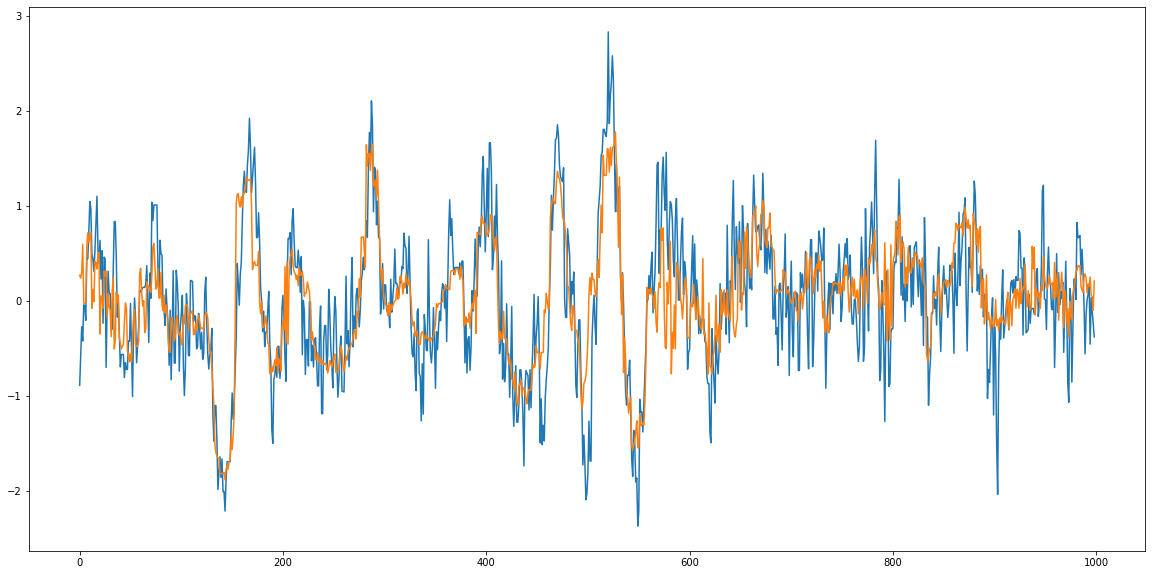

In [21]:
plt.plot(real_outputs1_all)
plt.plot(model_outputs1_all)

### Data set 2

In [22]:
model_outputs2 = list()
real_outputs2 = list()
errors2 = list()
for i in range(len(test2)):
    model_output = knn.predict(test2.drop(["LT01"],axis=1).values[i])
    real_output = test2["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs2.append(model_output)
    real_outputs2.append(real_output)
    errors2.append(error)

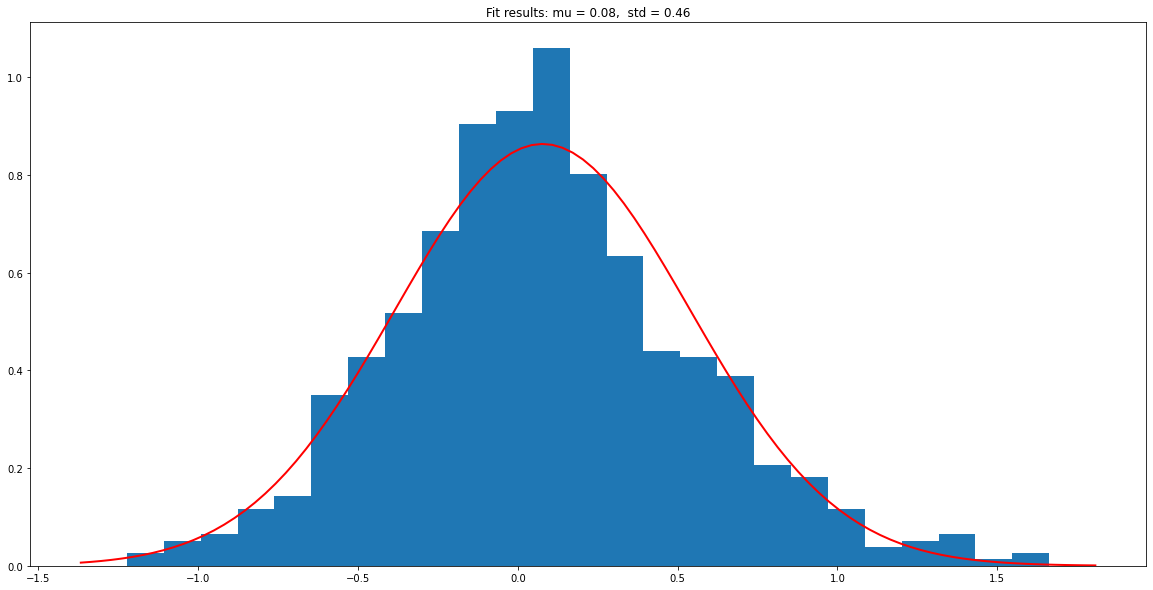

In [23]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors2, bins=25, density=True)

mu = np.array(errors2).mean()
sigma = np.array(errors2).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.8958603445354825


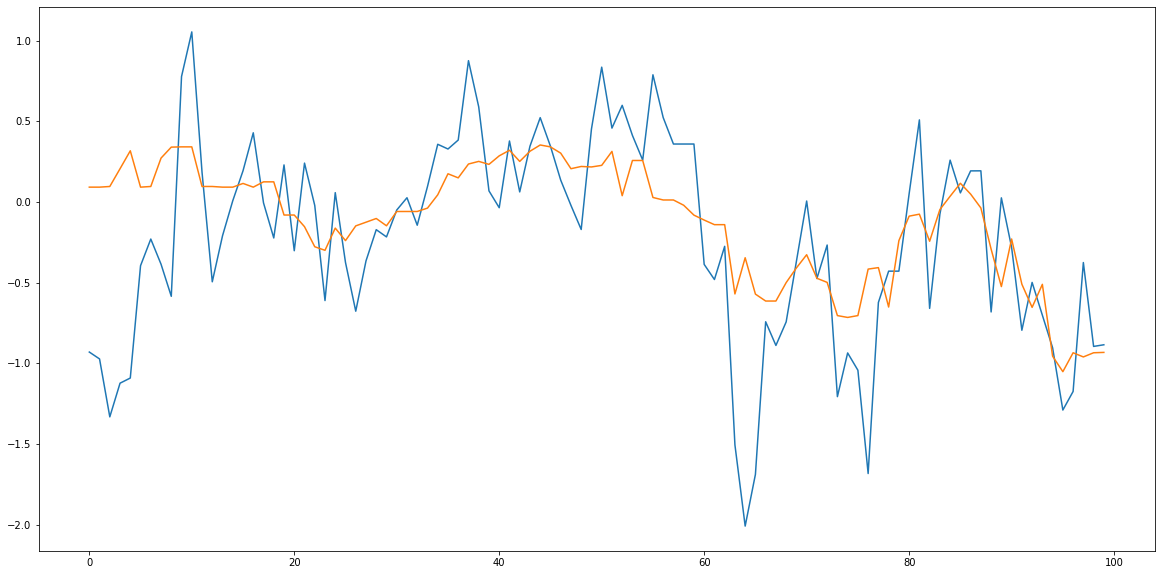

In [24]:
model_outputs2_all = list()
real_outputs2_all = list()
errors2_all = list()
for i in range(len(df2)):
    model_output = knn.predict(df2.drop(["LT01"],axis=1).values[i])
    real_output = df2["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs2_all.append(model_output)
    real_outputs2_all.append(real_output)
    errors2_all.append(error)

plt.plot(real_outputs2_all[:100])
plt.plot(model_outputs2_all[:100])
r2_lt_2 = r2_score(real_outputs2_all, model_outputs2_all)
print(r2_lt_2)

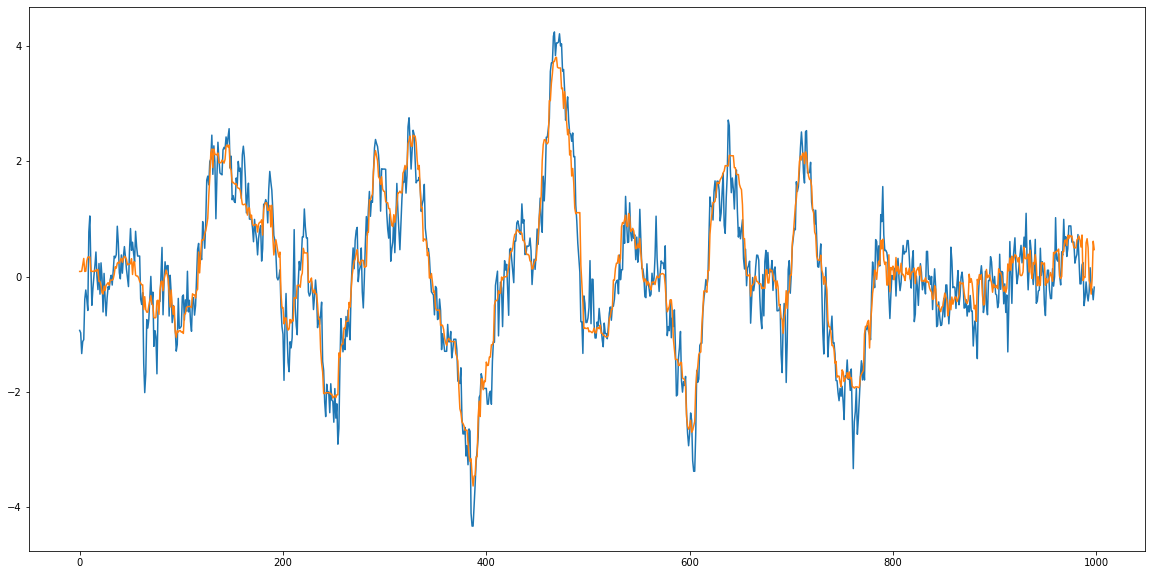

In [25]:
plt.plot(real_outputs2_all)
plt.plot(model_outputs2_all)

### Data set 3

In [26]:
model_outputs3 = list()
real_outputs3 = list()
errors3 = list()
for i in range(len(test3)):
    model_output = knn.predict(test3.drop(["LT01"],axis=1).values[i])
    real_output = test3["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs3.append(model_output)
    real_outputs3.append(real_output)
    errors3.append(error)

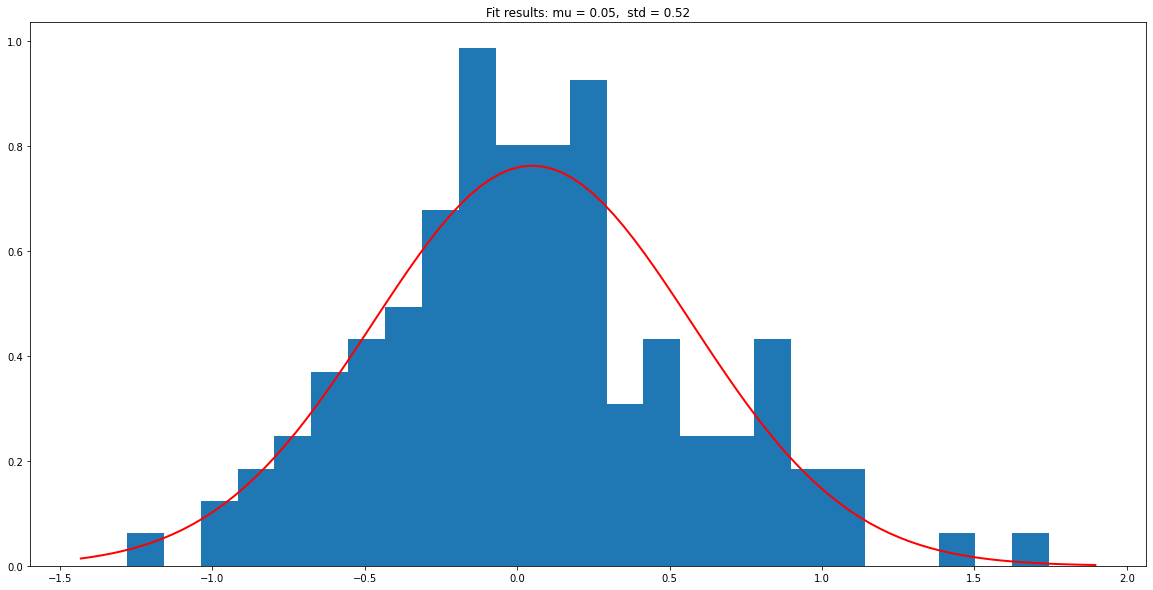

In [27]:
hist = plt.hist(errors3, bins=25, density=True)
mu = np.array(errors3).mean()
sigma = np.array(errors3).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.17884910974746782


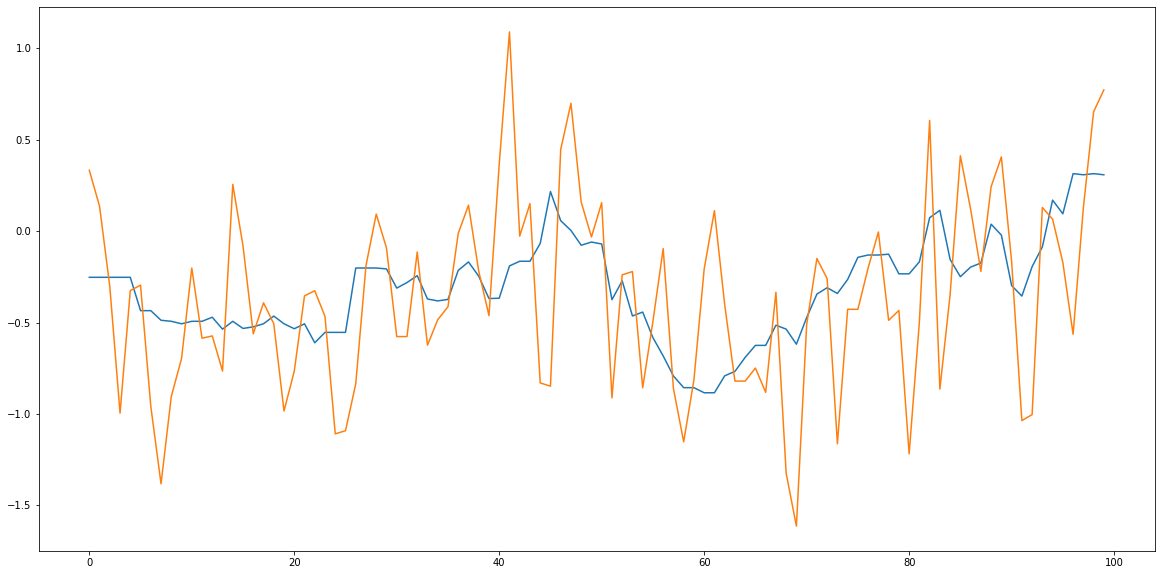

In [28]:
model_outputs3_all = list()
real_outputs3_all = list()
errors3_all = list()
for i in range(len(df3)):
    model_output = knn.predict(df3.drop(["LT01"],axis=1).values[i])
    real_output = df3["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs3_all.append(model_output)
    real_outputs3_all.append(real_output)
    errors3_all.append(error)

plt.plot(model_outputs3_all[:100])
plt.plot(real_outputs3_all[:100])
r2_lt_3 = r2_score(model_outputs3_all, real_outputs3_all)
print(r2_lt_3)

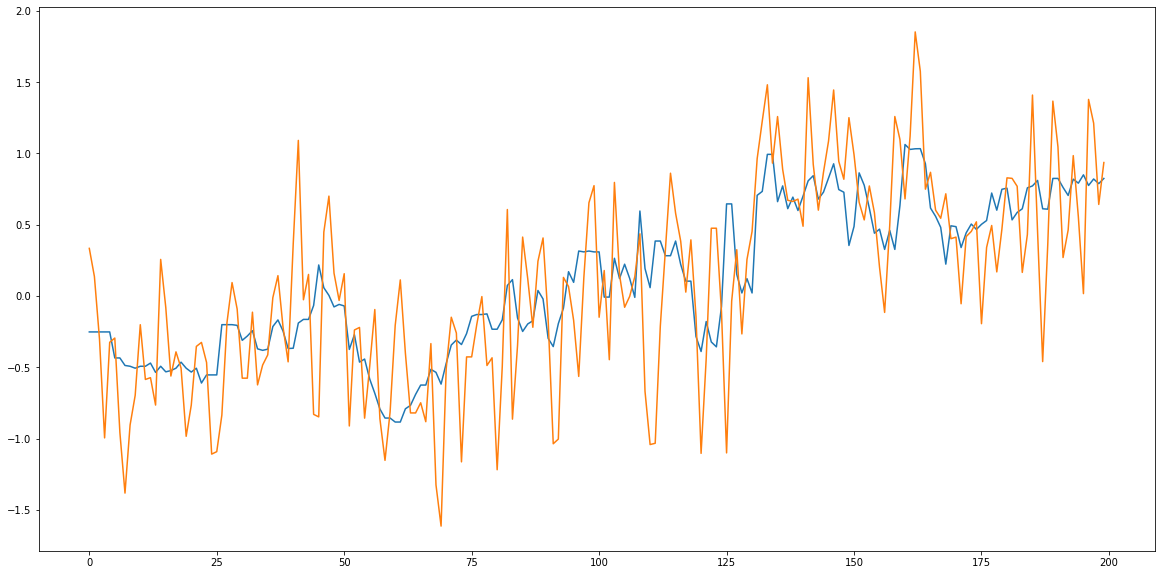

In [29]:
plt.plot(model_outputs3_all)
plt.plot(real_outputs3_all)

## DP

In [30]:
all_dfs = scaledDataFrames[0].append(scaledDataFrames[1]).append(scaledDataFrames[2]).append(scaledDataFrames[3])
scaled_inputs_dp = all_dfs.drop(["DP"], axis=1)

pca_dp = PCA(0.99)
pca_dp.fit(scaled_inputs_dp)

principal_components_dp = list()
for sdf in scaledDataFrames:
    pc = pca_dp.transform(sdf.drop(["DP"], axis=1))
    principal_components_dp.append(pd.DataFrame(pc))

In [31]:
principal_components_dp[0]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.659670,-2.953216,0.860753,-1.206165,-0.228377,-0.127831,0.271624,-0.677552,0.052153,-0.288716,...,-0.329997,-0.325094,-0.136622,0.052503,0.084203,0.122147,-0.036636,0.234579,0.176843,-0.245343
1,-2.568017,-2.997576,0.755587,-1.192654,-0.196687,-0.137448,0.405000,-0.567508,-0.054540,-0.580198,...,-0.374865,-0.364321,-0.174108,0.002016,0.131133,0.064407,-0.074873,0.271301,0.299040,-0.237404
2,-2.636561,-2.946749,0.850927,-1.174554,-0.188278,-0.080120,0.388385,-0.639896,0.047502,-0.249516,...,-0.316354,-0.324442,-0.165452,0.025396,0.113372,0.201848,0.020462,0.204628,0.200715,-0.171505
3,-2.607062,-2.900865,0.902313,-1.280743,-0.152723,-0.088474,0.248861,-0.704979,0.163668,0.020771,...,-0.333896,-0.252331,-0.136351,0.072870,0.124030,-0.005740,-0.063046,0.156058,0.283376,-0.284960
4,-2.606674,-2.893049,0.940955,-1.307445,-0.243439,-0.167663,0.133358,-0.767468,0.209866,0.012640,...,-0.356134,-0.244378,-0.097183,0.088278,0.094784,-0.008338,-0.088294,0.155268,0.220474,-0.351915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-3.526390,-4.826104,-0.343438,0.242560,-1.469067,0.150424,-2.127285,3.066771,-2.136640,2.180939,...,-0.333455,-0.364583,-0.271750,-0.851420,-0.211685,-0.319557,-0.168628,0.290996,-0.298583,0.264286
995,-3.510890,-5.227006,-0.503423,0.210138,-1.725204,0.511605,-2.072651,2.437219,-1.764633,2.080834,...,-0.144678,-0.153180,-0.376351,-0.703784,-0.402881,-0.015391,0.135098,0.173157,-0.293691,0.067531
996,-3.531634,-5.498440,-0.779243,0.204518,-1.918035,0.837965,-1.543771,2.049469,-1.338183,1.808642,...,0.028209,-0.162851,-0.668730,-0.426540,-0.291108,-0.134524,0.150933,0.329031,-0.187241,0.150397
997,-3.406971,-5.680566,-1.037574,0.266016,-1.854922,0.705380,-1.361671,1.866463,-1.150796,1.561050,...,-0.103738,-0.000586,-0.776450,-0.466299,-0.242160,-0.153039,0.035144,0.485909,-0.069400,-0.080387


In [32]:
df0_dp = principal_components_dp[0].copy()
df0_dp.insert(22, "DP", scaledDataFrames[0]["DP"].values)
[train0_dp, test0_dp] = train_test_split(df0_dp, train_size=TRAINTESTRATIO, random_state=0)

df1_dp = principal_components_dp[1].copy()
df1_dp.insert(22, "DP", scaledDataFrames[1]["DP"].values)
[train1_dp, test1_dp] = train_test_split(df1_dp, train_size=TRAINTESTRATIO, random_state=0)

df2_dp = principal_components_dp[2].copy()
df2_dp.insert(22, "DP", scaledDataFrames[2]["DP"].values)
[train2_dp, test2_dp] = train_test_split(df2_dp, train_size=TRAINTESTRATIO, random_state=0)

df3_dp = principal_components_dp[3].copy()
df3_dp.insert(22, "DP", scaledDataFrames[3]["DP"].values)
[train3_dp, test3_dp] = train_test_split(df3_dp, train_size=TRAINTESTRATIO, random_state=0)

In [33]:
knndp = KNNRegressor(k=KN)
for idx, row in enumerate(zip(train0_dp.drop(["DP"],axis=1).iterrows(), train0_dp["DP"])):
    inputs = row[0][1].values
    output = row[1]
    knndp.add_data(inputs, output)
    
for idx, row in enumerate(zip(train1_dp.drop(["DP"],axis=1).iterrows(), train1_dp["DP"])):
    inputs = row[0][1].values
    output = row[1]
    knndp.add_data(inputs, output)
    
for idx, row in enumerate(zip(train2_dp.drop(["DP"],axis=1).iterrows(), train2_dp["DP"])):
    inputs = row[0][1].values
    output = row[1]
    knndp.add_data(inputs, output)
    
for idx, row in enumerate(zip(train3_dp.drop(["DP"],axis=1).iterrows(), train3_dp["DP"])):
    inputs = row[0][1].values
    output = row[1]
    knndp.add_data(inputs, output)

### Data set 0

In [34]:
model_outputs0_dp = list()
real_outputs0_dp = list()
errors0_dp = list()
for i in range(len(test0)):
    model_output = knndp.predict(test0_dp.drop(["DP"],axis=1).values[i])
    real_output = test0_dp["DP"].values[i]
    error = (model_output - real_output)
    
    model_outputs0_dp.append(model_output)
    real_outputs0_dp.append(real_output)
    errors0_dp.append(error)

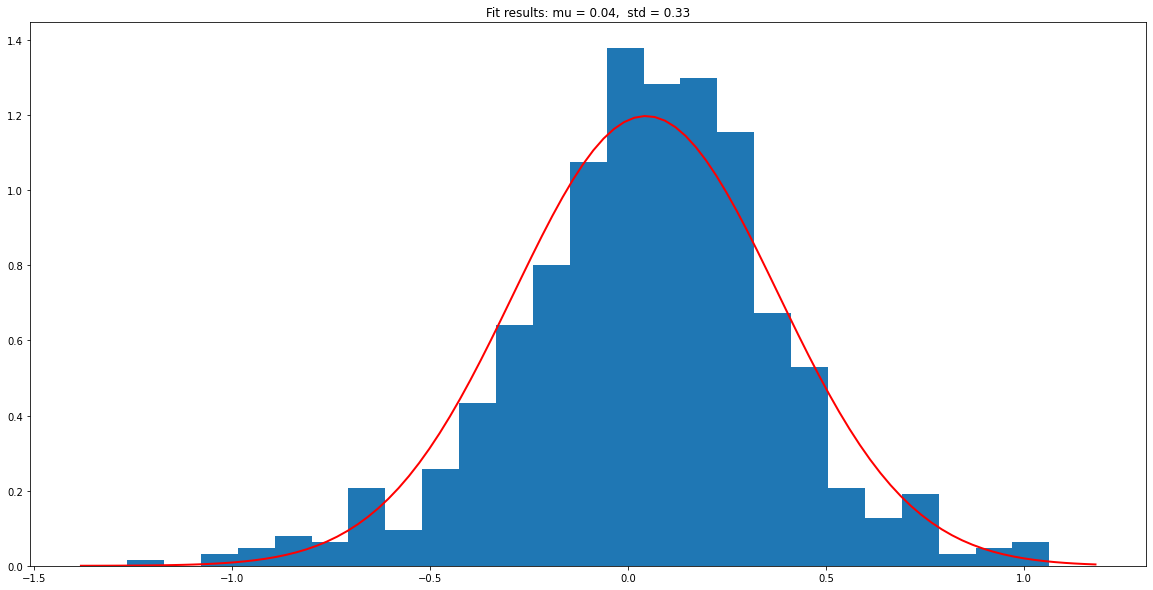

In [35]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors0_dp, bins=25, density=True)

mu = np.array(errors0_dp).mean()
sigma = np.array(errors0_dp).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.8399303665995759


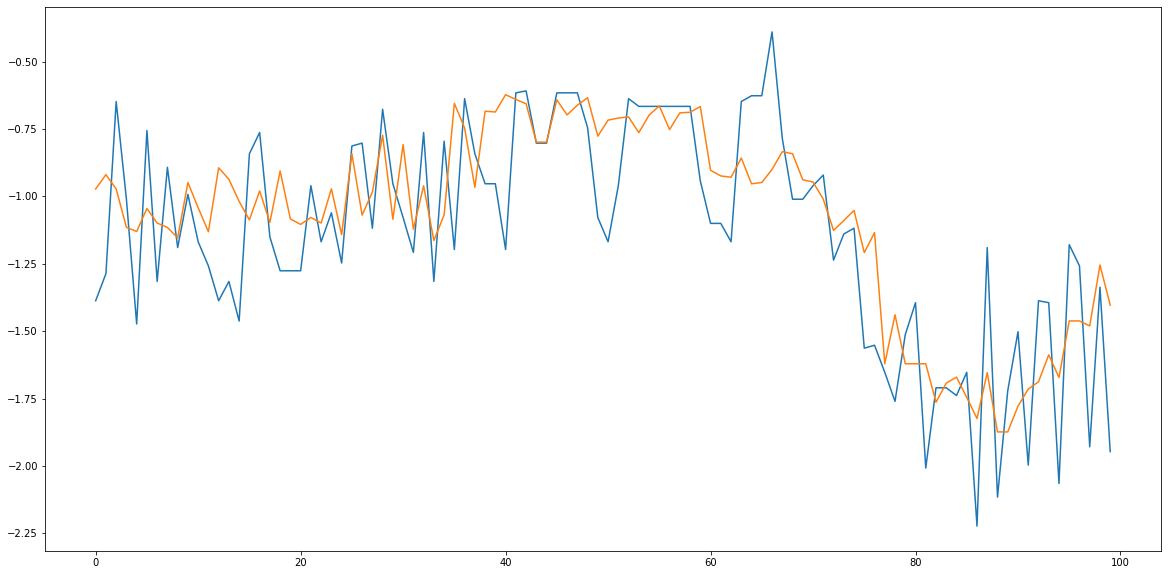

In [36]:
model_outputs0_all_dp = list()
real_outputs0_all_dp = list()
errors0_all_dp = list()
for i in range(len(df0_dp)):
    model_output = knndp.predict(df0_dp.drop(["DP"],axis=1).values[i])
    real_output = df0_dp["DP"].values[i]
    error = (model_output - real_output)
    
    model_outputs0_all_dp.append(model_output)
    real_outputs0_all_dp.append(real_output)
    errors0_all_dp.append(error)

plt.plot(real_outputs0_all_dp[:100])
plt.plot(model_outputs0_all_dp[:100])
r2_dp_0 = r2_score(real_outputs0_all_dp, model_outputs0_all_dp)
print(r2_dp_0)

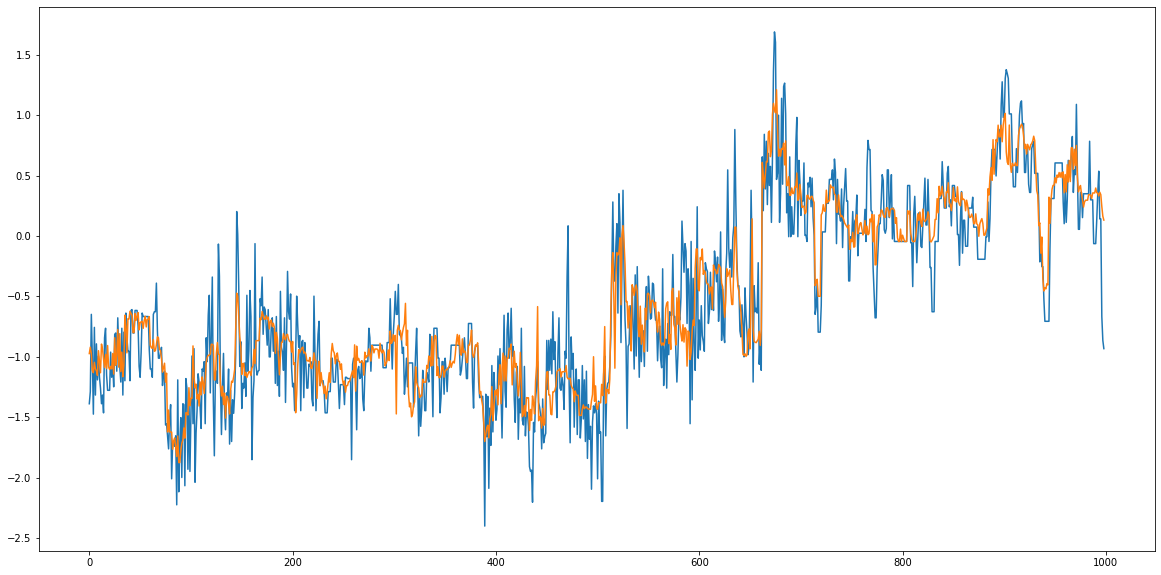

In [37]:
plt.plot(real_outputs0_all_dp)
plt.plot(model_outputs0_all_dp)

### Data set 1

In [38]:
model_outputs1_dp = list()
real_outputs1_dp = list()
errors1_dp = list()
for i in range(len(test1_dp)):
    model_output = knndp.predict(test1_dp.drop(["DP"],axis=1).values[i])
    real_output = test1_dp["DP"].values[i]
    error = (model_output - real_output)
    
    model_outputs1_dp.append(model_output)
    real_outputs1_dp.append(real_output)
    errors1_dp.append(error)

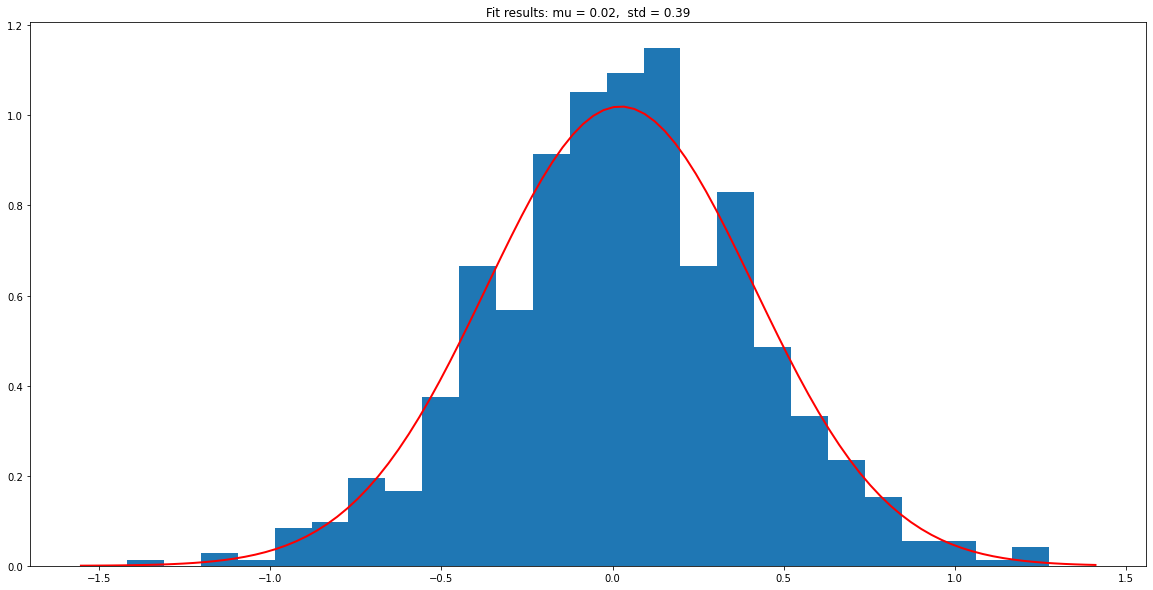

In [39]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors1_dp, bins=25, density=True)

mu = np.array(errors1_dp).mean()
sigma = np.array(errors1_dp).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.45611068355790807


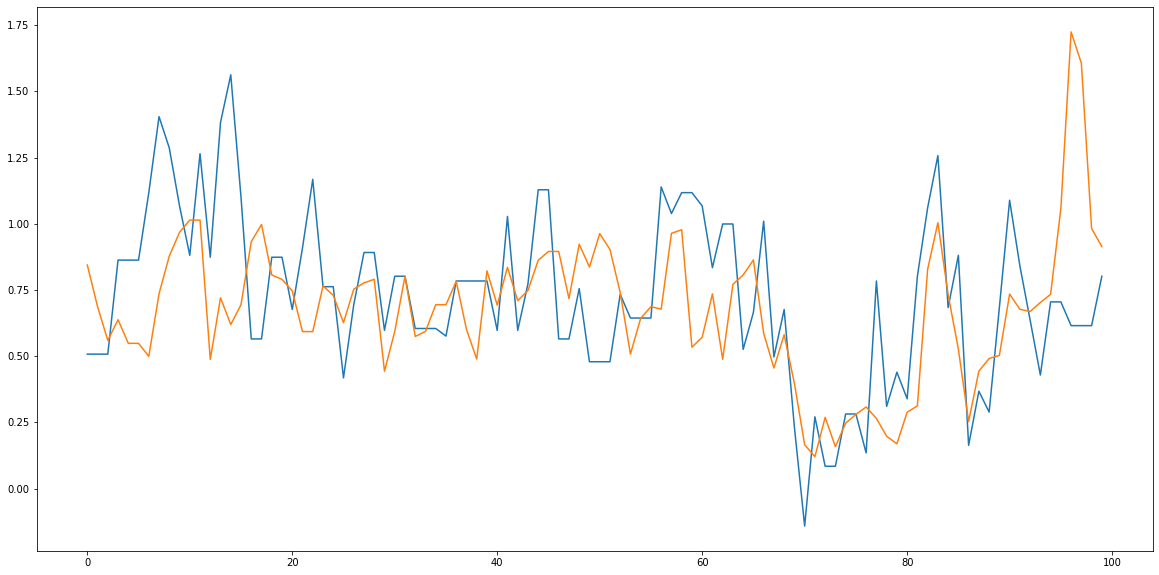

In [40]:
model_outputs1_all_dp = list()
real_outputs1_all_dp = list()
errors1_all_dp = list()
for i in range(len(df1_dp)):
    model_output = knndp.predict(df1_dp.drop(["DP"],axis=1).values[i])
    real_output = df1_dp["DP"].values[i]
    error = (model_output - real_output)
    
    model_outputs1_all_dp.append(model_output)
    real_outputs1_all_dp.append(real_output)
    errors1_all_dp.append(error)

plt.plot(real_outputs1_all_dp[:100])
plt.plot(model_outputs1_all_dp[:100])
r2_dp_1 = r2_score(real_outputs1_all_dp, model_outputs1_all_dp)
print(r2_dp_1)

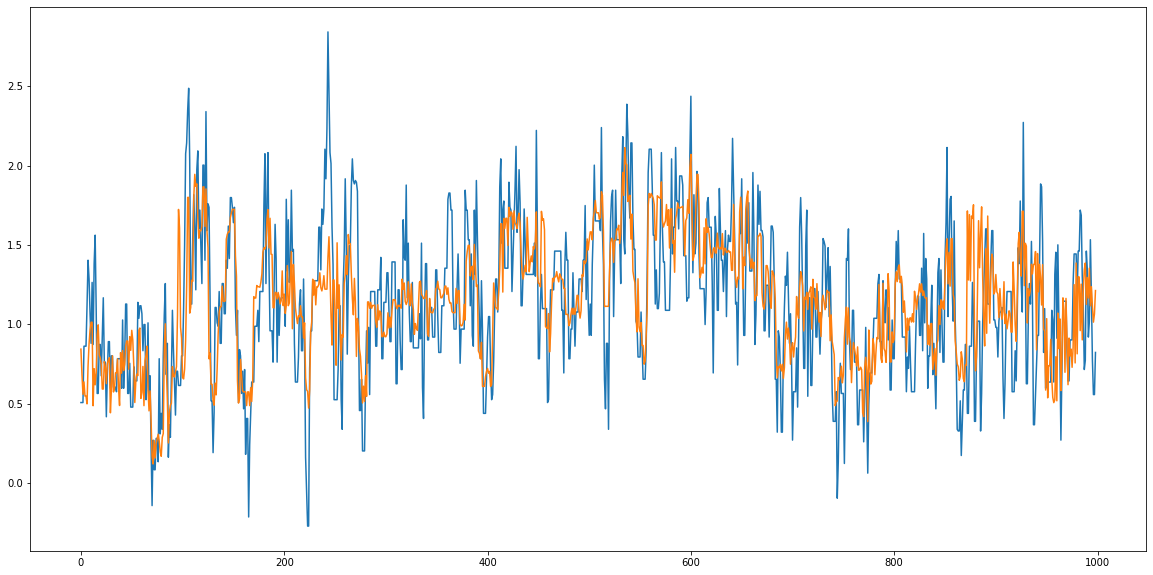

In [41]:
plt.plot(real_outputs1_all_dp)
plt.plot(model_outputs1_all_dp)

### Data set 2

In [42]:
model_outputs2_dp = list()
real_outputs2_dp = list()
errors2_dp = list()
for i in range(len(test2_dp)):
    model_output = knndp.predict(test2_dp.drop(["DP"],axis=1).values[i])
    real_output = test2_dp["DP"].values[i]
    error = (model_output - real_output)
    
    model_outputs2_dp.append(model_output)
    real_outputs2_dp.append(real_output)
    errors2_dp.append(error)

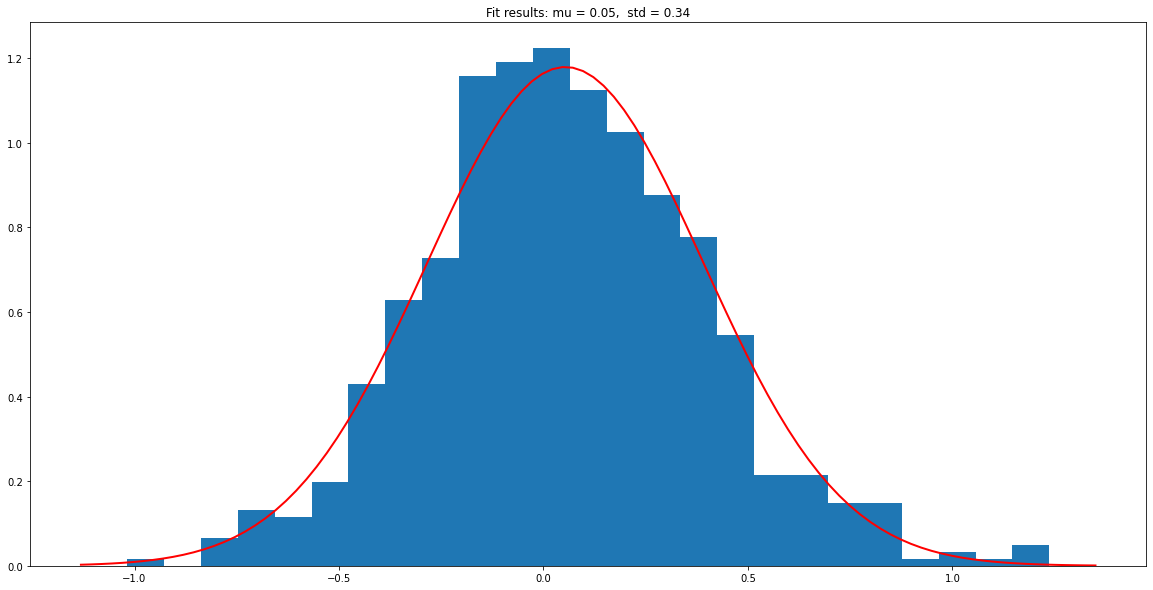

In [43]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors2_dp, bins=25, density=True)

mu = np.array(errors2_dp).mean()
sigma = np.array(errors2_dp).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.7350067401603553


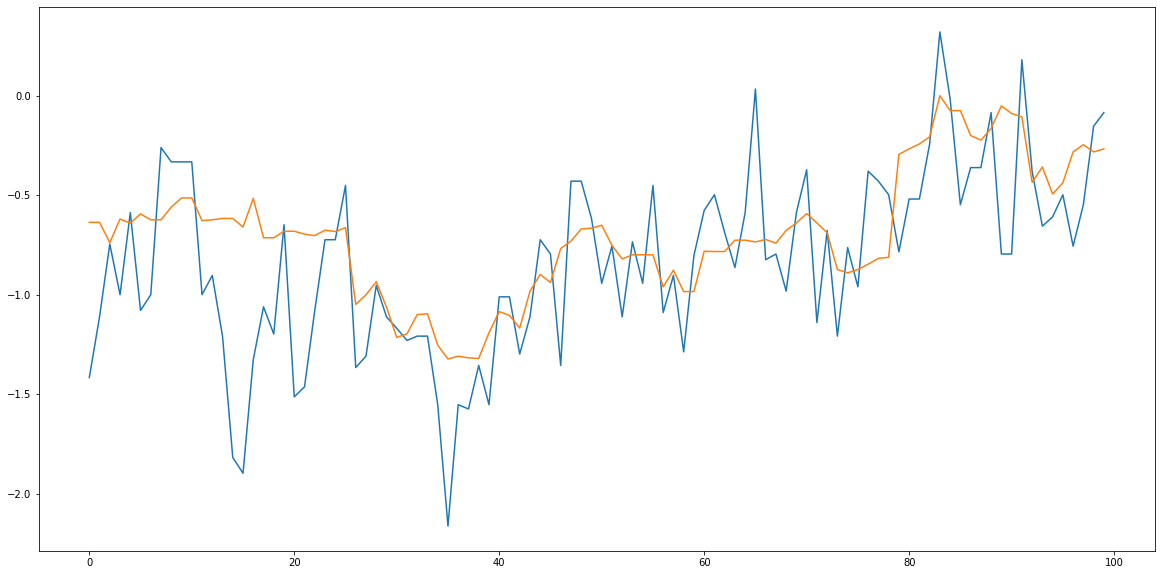

In [44]:
model_outputs2_all_dp = list()
real_outputs2_all_dp = list()
errors2_all_dp = list()
for i in range(len(df1_dp)):
    model_output = knndp.predict(df2_dp.drop(["DP"],axis=1).values[i])
    real_output = df2_dp["DP"].values[i]
    error = (model_output - real_output)
    
    model_outputs2_all_dp.append(model_output)
    real_outputs2_all_dp.append(real_output)
    errors2_all_dp.append(error)

plt.plot(real_outputs2_all_dp[:100])
plt.plot(model_outputs2_all_dp[:100])
r2_dp_2 = r2_score(real_outputs2_all_dp, model_outputs2_all_dp)
print(r2_dp_2)

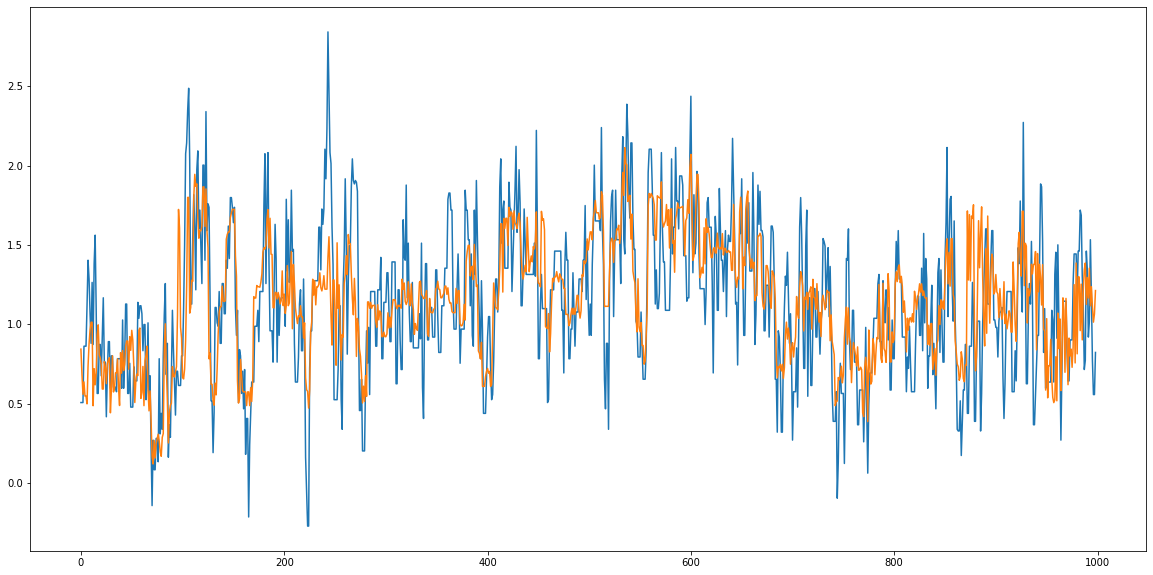

In [45]:
plt.plot(real_outputs1_all_dp)
plt.plot(model_outputs1_all_dp)

### Data set 3

In [46]:
model_outputs3_dp = list()
real_outputs3_dp = list()
errors3_dp = list()
for i in range(len(test3_dp)):
    model_output = knndp.predict(test3_dp.drop(["DP"],axis=1).values[i])
    real_output = test3_dp["DP"].values[i]
    error = (model_output - real_output)
    
    model_outputs3_dp.append(model_output)
    real_outputs3_dp.append(real_output)
    errors3_dp.append(error)

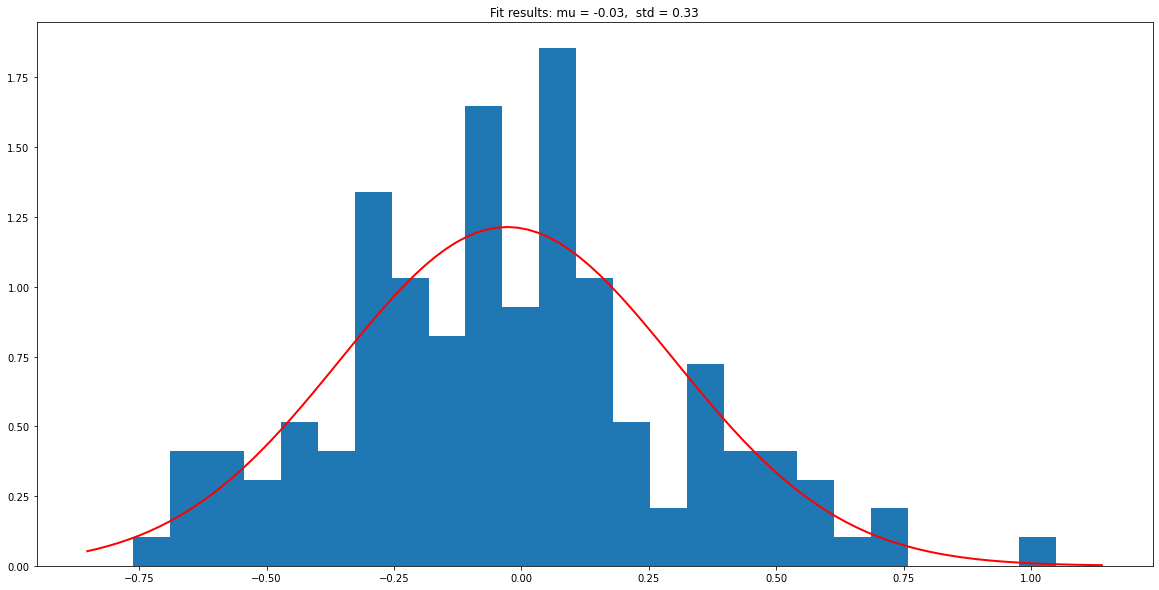

In [47]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors3_dp, bins=25, density=True)

mu = np.array(errors3_dp).mean()
sigma = np.array(errors3_dp).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.8259995504150257


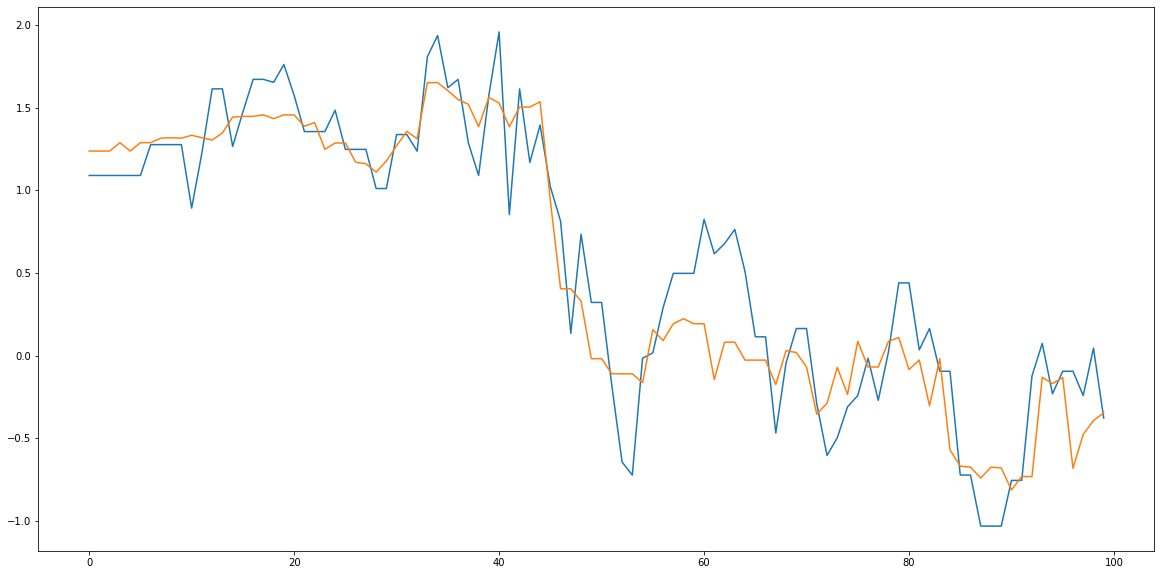

In [48]:
model_outputs3_all_dp = list()
real_outputs3_all_dp = list()
errors3_all_dp = list()
for i in range(len(df3_dp)):
    model_output = knndp.predict(df3_dp.drop(["DP"],axis=1).values[i])
    real_output = df3_dp["DP"].values[i]
    error = (model_output - real_output)
    
    model_outputs3_all_dp.append(model_output)
    real_outputs3_all_dp.append(real_output)
    errors3_all_dp.append(error)

plt.plot(real_outputs3_all_dp[:100])
plt.plot(model_outputs3_all_dp[:100])
r2_dp_3 = r2_score(real_outputs3_all_dp, model_outputs3_all_dp)
print(r2_dp_3)

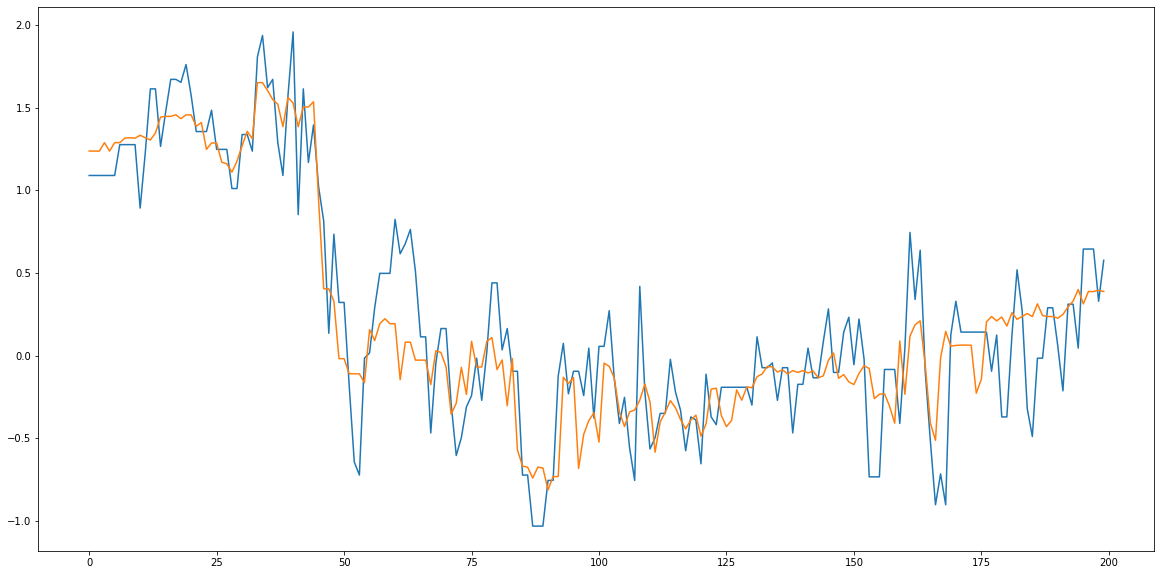

In [49]:
plt.plot(real_outputs3_all_dp)
plt.plot(model_outputs3_all_dp)

### Podsumowanie

In [50]:
print(f"Średnie r2 dla LT01: {sum([r2_lt_0, r2_lt_1, r2_lt_2, r2_lt_3])/4}")
print(f"Średnie r2 dla DP: {sum([r2_dp_0, r2_dp_1, r2_dp_2, r2_dp_3])/4}")

Średnie r2 dla LT01: 0.5994087232093461
Średnie r2 dla DP: 0.7142618351832162


In [67]:
pdres = pd.DataFrame(np.array([real_outputs0_all, model_outputs0_all]).transpose())
pdres.to_csv("./results/knn/lt01_0.csv", index=False, header=False)
pdres = pd.DataFrame(np.array([real_outputs1_all, model_outputs1_all]).transpose())
pdres.to_csv("./results/knn/lt01_1.csv", index=False, header=False)
pdres = pd.DataFrame(np.array([real_outputs2_all, model_outputs2_all]).transpose())
pdres.to_csv("./results/knn/lt01_2.csv", index=False, header=False)
pdres = pd.DataFrame(np.array([real_outputs3_all, model_outputs3_all]).transpose())
pdres.to_csv("./results/knn/lt01_3.csv", index=False, header=False)

pdres = pd.DataFrame(np.array([real_outputs0_all_dp, model_outputs0_all_dp]).transpose())
pdres.to_csv("./results/knn/dp_0.csv", index=False, header=False)
pdres = pd.DataFrame(np.array([real_outputs1_all_dp, model_outputs1_all_dp]).transpose())
pdres.to_csv("./results/knn/dp_1.csv", index=False, header=False)
pdres = pd.DataFrame(np.array([real_outputs2_all_dp, model_outputs2_all_dp]).transpose())
pdres.to_csv("./results/knn/dp_2.csv", index=False, header=False)
pdres = pd.DataFrame(np.array([real_outputs3_all_dp, model_outputs3_all_dp]).transpose())
pdres.to_csv("./results/knn/dp_3.csv", index=False, header=False)